In [3]:
# Code to evaluate the performance of the classifier layer using NEMO Classifier

# Import Libraries

#from ConfigParser import SafeConfigParser
from PIL import Image, ExifTags

import pynemo
import multiprocessing
import scipy.ndimage
import numpy as np
%matplotlib inline
from pylab import *
import caffe
#import h5py
import time
import cv2
import os
import csv
import scipy 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

#sys.path.append('utils')
from utils.TrainNet import train, trainXSteps
from utils.Vis import vis_make_palette, vis_color_seg, checkEXIFRotation

# caffe.set_mode_cpu()
# print("CPU mode")

caffe.set_mode_gpu()
caffe.set_device(0)
# caffe.set_mode_cpu()

print("GPU mode")

print('OK')

GPU mode
OK


In [4]:
def get_net(protxt_file, caffemodel_file):
    # This function returns the caffemodel
    return caffe.Net( protxt_file, caffemodel_file, caffe.TEST)

# protxt_file = '/opt/caffe/neurala/training-pipeline/models/FullDenseNet/FullDenseNet-Forward.prototxt'
protxt_file = '/opt/caffe/neurala/training-pipeline/models/classifier/CIFAR_model/architecture_files/signet1024ss-10.prototxt'
# protxt_file = '/opt/caffe/neurala/training-pipeline/models/classifier/classifier_1500/deploy.prototxt'
# caffemodel_file = '/opt/caffe/neurala/training-pipeline/models/weights/snapshot_iter_40000.caffemodel'
caffemodel_file = '/opt/caffe/neurala/training-pipeline/models/classifier/CIFAR_model/CIFAR_caffemodels/signet1024ss-CIFAR-10.caffemodel'
# caffemodel_file = '/opt/caffe/neurala/training-pipeline/models/classifier/classifier_1500/snapshot_iter_1550.caffemodel'

# net = get_net(protxt_file, caffemodel_file)

In [5]:
path = '/opt/caffe/neurala/training-pipeline/models/classifier/CIFAR_dataset/data'

In [6]:
labels = """airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck"""

_classes = {i: v.replace(' ', '_') for i, v in enumerate(labels.split('\n'))}

print(_classes[1])
print(_classes)

automobile
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [7]:
def get_image():
    """
    Function to load image locations, corresponding ground truth classes for classification from test
    
    return:
    A list with each individual image of the form
    [Image_location in str], [Ground truth of image classification]
    """
    # Reference the directory of the GVDL folder
    img_loc = path + '/test.list'
    data = [] 
    gt = []
    with open(img_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='-')
        for row in reader:
            data.append(path + '/test/' + row[0] + '-' + row[1])
            gt.append(row[1][:-4])
    return data, gt

def get_train_image():
    """
    Function to load image locations, corresponding ground truth classes for classification from train

    return:
    A list with each individual image of the form
    [Image_location in str], [Ground truth of image classification]
    """
    # Reference the directory of the GVDL folder
    img_loc = path + '/train.list'
    data = [] 
    gt = []
    with open(img_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel')
        for row in reader:
#             print(row[0])
            data.append(path + '/train/' + row[0])
#             print(row[0].split("-")[2][:-4])
            gt.append(row[0].split("-")[2][:-4])
    return data, gt



In [8]:
def normailize(im_arr):
    range = im_arr.max() - im_arr.min() 
    im_arr = (im_arr - im_arr.min()) / range - 0.5
    return im_arr

def subtract_mean(im_arr):
    # This function was needed for classifier_1500 model which has a great accuracy. It needs mean subtraction
    im_src = '/opt/caffe/neurala/training-pipeline/models/classifier/classifier_1500/image.png'
    im = Image.open(im_src)
    im = np.asarray(im)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    im = np.int32(im)
    im_arr = np.int32(im_arr) 
    temp = (im_arr - im[:,:,0:3])
    return temp


def classifier(protxt_file, caffemodel_file, myImagePath, gt):
#     Get the model ready
    net = get_net(protxt_file, caffemodel_file)
#     print("loaded the net successfully")
    im = Image.open(myImagePath)
    im_arr = np.asarray(im)
    
#     We need to rotate the image by 90 degrees
    h,w,_ = np.shape(im_arr)
    center = (w / 2, h / 2) 
    M = cv2.getRotationMatrix2D(center, 90, 1) 
    im_arr = cv2.warpAffine(im_arr, M, (h, w)) 
    
#     fig1,ax1 = plt.subplots(1)
#     ax1.imshow(im_arr)
    
    im_arr = cv2.cvtColor(im_arr, cv2.COLOR_RGB2BGR)
#     im_arr = cv2.flip( im_arr, 0)  # Use this to flip images

#     fig1,ax1 = plt.subplots(1)
#     ax1.imshow(im_arr)
#     im_arr = subtract_mean(im_arr) # use this for classifier_1500
    
    im_arr = normailize(im_arr)      # Needed for Signet-1024ss

    im_data = im_arr.transpose((2,1,0))
#     print("The shape of im_data is ", np.shape(im_data))
    img_list = []
    img_list.append(im_data)
#     print("The shape of img_list is ", np.shape(img_list))
    net.blobs['data'].reshape(*np.asarray(img_list).shape)
    net.blobs['data'].data[...] = img_list
    net.forward()
    class_output = net.blobs['softmax'].data
    return class_output

In [9]:
data,gt = get_image()
# data,gt = get_train_image()
print(len(data))


# Feed in the index of the image you want to evaluate
index = 15
pred = classifier(protxt_file, caffemodel_file, data[index], gt[index])
# print(pred)
li = pred[0]
pos = np.argmax(li)
# print(np.argmax(li))
print("The predicted class is", _classes[np.argmax(li)])
print("The True class is", gt[index])  # For testing
# print("The True class is", gt[index])    # For training

10000
The predicted class is automobile
The True class is automobile


In [10]:
count = 0
if (_classes[np.argmax(li)] == gt[index][:-4]):
    print("1")
    
# for training
if (_classes[np.argmax(li)] == gt[index]):
    print("1")

1


In [210]:
def evaluate():
    score = 0
    data,gt = get_image()
    correct_class = []
    wrong_class_gt = []
    wrong_class_pred = []
#     data,gt = get_train_image()
    for index in range(0,len(data)-9700):
        if (index%10==1):
            print("The accuracy at index",index-1,"is", score/index * 100, "%")
        pred = classifier(protxt_file, caffemodel_file, data[index], gt[index])
        li = pred[0]
        if (_classes[np.argmax(li)] == gt[index]):   # For test images
#         if (_classes[np.argmax(li)] == gt[index]):          # For train images
            correct_class.append(_classes[np.argmax(li)])
            score+=1
#             print(_classes[np.argmax(li)], index)
        else:
            wrong_class_gt.append(gt[index])
            wrong_class_pred.append(_classes[np.argmax(li)])
    return score, wrong_class_gt, wrong_class_pred, correct_class

In [211]:
ams, wrong_gt, wrong_pred, correct_pred = evaluate()

The accuracy at index 0 is 100.0 %
The accuracy at index 10 is 90.9090909090909 %
The accuracy at index 20 is 90.47619047619048 %
The accuracy at index 30 is 90.32258064516128 %
The accuracy at index 40 is 90.2439024390244 %
The accuracy at index 50 is 86.27450980392157 %
The accuracy at index 60 is 85.24590163934425 %
The accuracy at index 70 is 84.50704225352112 %
The accuracy at index 80 is 83.9506172839506 %
The accuracy at index 90 is 84.61538461538461 %
The accuracy at index 100 is 84.15841584158416 %
The accuracy at index 110 is 85.58558558558559 %
The accuracy at index 120 is 86.77685950413223 %
The accuracy at index 130 is 86.25954198473282 %
The accuracy at index 140 is 86.52482269503547 %
The accuracy at index 150 is 86.75496688741721 %
The accuracy at index 160 is 84.472049689441 %
The accuracy at index 170 is 84.21052631578947 %
The accuracy at index 180 is 83.97790055248619 %
The accuracy at index 190 is 84.29319371727748 %
The accuracy at index 200 is 84.5771144278607 %


In [212]:
True_Positive = {x:correct_pred.count(x) for x in sorted(correct_pred)}
False_Positive = {x:wrong_pred.count(x) for x in sorted(wrong_pred)}
# print(True_Positive)
# print(False_Positive)
# print(True_Positive.values())
# print(False_Positive.values())
TP_keys = np.fromiter(True_Positive.values(), dtype=int)
FP_keys = np.fromiter(False_Positive.values(), dtype=int)
# print(TP_keys)
# print(FP_keys)
prec = np.asarray([TP_keys[i]/(TP_keys[i] + FP_keys[i]) for i in range(len(TP_keys))])
print("The Mean Precision is", np.mean(prec))
# print(prec)

The Mean Precision is 0.8438900976400976


In [213]:
import pandas
from collections import Counter
def plot_graph(a, title2):
    class_count = Counter(a)
    df = pandas.DataFrame.from_dict(class_count, orient='index')
    df.plot(kind='bar', title = title2)
    df.title = title

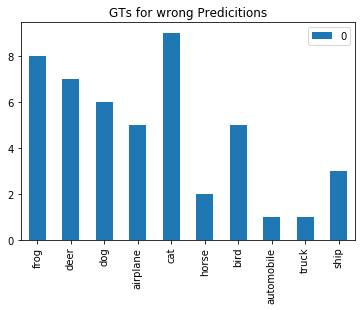

In [214]:
plot_graph(wrong_gt, "GTs for wrong Predicitions")

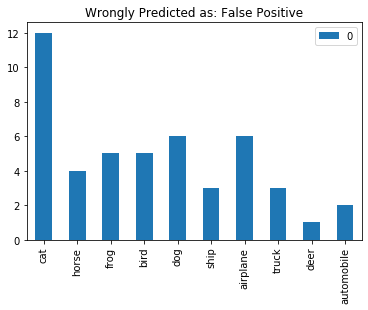

In [215]:
plot_graph(wrong_pred, "Wrongly Predicted as: False Positive")

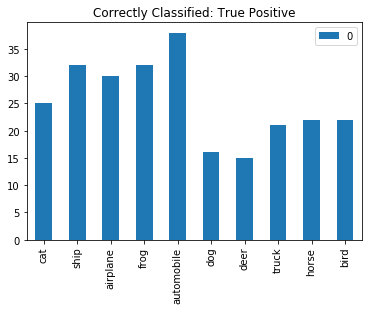

In [216]:
plot_graph(correct_pred, "Correctly Classified: True Positive")

In [217]:
# SDK Calculation
sdk = np.array([0.822,0.885,0.855, 0.817, 0.947, 0, 0.75, 0.714, 0.756, 0.781])
print(np.mean(sdk))

0.7326999999999999


In [11]:
def get_pool(protxt_file, caffemodel_file, myImagePath, gt):
#     Get the model ready
    net = get_net(protxt_file, caffemodel_file)
#     print("loaded the net successfully")
    im = Image.open(myImagePath)
    im_arr = np.asarray(im)
    
#     We need to rotate the image by 90 degrees
    h,w,_ = np.shape(im_arr)
    center = (w / 2, h / 2) 
    M = cv2.getRotationMatrix2D(center, 90, 1) 
    im_arr = cv2.warpAffine(im_arr, M, (h, w)) 
    
#     fig1,ax1 = plt.subplots(1)
#     ax1.imshow(im_arr)
    
    im_arr = cv2.cvtColor(im_arr, cv2.COLOR_RGB2BGR)
#     im_arr = cv2.flip( im_arr, 0)  # Use this to flip images

#     fig1,ax1 = plt.subplots(1)
#     ax1.imshow(im_arr)
#     im_arr = subtract_mean(im_arr) # use this for classifier_1500
    
    im_arr = normailize(im_arr)      # Needed for Signet-1024ss

    im_data = im_arr.transpose((2,1,0))
#     print("The shape of im_data is ", np.shape(im_data))
    img_list = []
    img_list.append(im_data)
#     print("The shape of img_list is ", np.shape(img_list))
    net.blobs['data'].reshape(*np.asarray(img_list).shape)
    net.blobs['data'].data[...] = img_list
    net.forward()
    class_output = net.blobs['global_pool'].data
    return class_output

In [158]:
def data_pool(index):
#     This function return data given index
    pool = get_pool(protxt_file, caffemodel_file, data[index], gt[index])
    pool_data = pool[0 ,:,0]
    return pool_data[:,0]

# index_arr_train = (65,100,3, 70)
# index_arr_train = tuple(i for i in range(5000))
# img_list_input = list(map(data_pool, index_arr_train))
# gt_list = [gt[i] for i in index_arr_train]

data,gt = get_train_image()
index_arr_train = tuple(i for i in range(7500))
img_list_input = list(map(data_pool, index_arr_train))
gt_list = [gt[i] for i in index_arr_train]

# print("The training gts are", gt_list)
nemo = pynemo.nemo(dominance=1.6, m_learningRate=1, is_input_prenormalized=True)
# nemo = pynemo.nemo()
# nemo.learn(inputs=[[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]], labels=["one", "two", "three"])
# predictions = nemo.predict_proba([[4, 5, 6, 7],[5, 6, 7, 8],[9, -10, 11, -12]], omit_nothing = False)
# print(predictions)
nemo.learn(inputs = np.asarray(img_list_input), labels = np.asarray(gt_list))

7500

In [159]:
# # This block of code can be deleted

# data,gt = get_nemo_test_image()
# # data,gt = get_train_image() 
# # index_nemo_test = tuple(i for i in range(len(data)))     # Test for NEMO with blank images
# img_list_test = list(map(data_pool, index_nemo_test))
# gt_list_test =  [gt[i] for i in range(len(data))]
# predictions = nemo.predict_proba(np.asarray(img_list_test), omit_nothing = False)
# # print("The testing gts are", gt_list_test[:])
# print(gt)
# print(predictions)

In [160]:
data,gt = get_image()
index_arr_test = tuple(i for i in range(1000))
img_list_test = list(map(data_pool, index_arr_test))
gt_list_test =  [gt[i] for i in index_arr_test]
predictions = nemo.predict_proba(img_list_test, omit_nothing = False)
# print("The testing gts are", gt_list_test[:])
# print()
# print(predictions)

In [161]:
preds = predictions.idxmax(axis=1)
# preds = re.sub('[$]', '', preds)
pred_class = [preds[i] for i in range (len(preds))]
# pred_class

In [162]:
def evaluate_nemo(truth, pred):
    correct_class = []
    wrong_class_gt = []
    wrong_class_pred = []
    score = 0
    for i in range(len(truth)):
        if (truth[i] == pred[i]):
            score += 1
            correct_class.append(truth[i])
        else:
            wrong_class_gt.append(truth[i])
            wrong_class_pred.append(pred[i])
    return score, wrong_class_gt, wrong_class_pred, correct_class
    

In [163]:
score, wrong_gt, wrong_pred, correct_pred = evaluate_nemo(gt_list_test, pred_class)
True_Positive = {x:correct_pred.count(x) for x in sorted(correct_pred)}
False_Positive = {x:wrong_pred.count(x) for x in sorted(wrong_pred)}
False_Positive2 = {x:wrong_pred.count(x) for x in sorted(correct_pred)}  # Does not include the 'Nothing I Know' class 
print(True_Positive)
print(False_Positive)
print(False_Positive2)

{'airplane': 85, 'automobile': 104, 'bird': 67, 'cat': 56, 'deer': 80, 'dog': 79, 'frog': 86, 'horse': 62, 'ship': 106, 'truck': 77}
{'Nothing I know': 6, 'airplane': 28, 'automobile': 6, 'bird': 17, 'cat': 29, 'deer': 22, 'dog': 48, 'frog': 8, 'horse': 6, 'ship': 25, 'truck': 3}
{'airplane': 28, 'automobile': 6, 'bird': 17, 'cat': 29, 'deer': 22, 'dog': 48, 'frog': 8, 'horse': 6, 'ship': 25, 'truck': 3}


In [164]:
TP_keys = np.fromiter(True_Positive.values(), dtype=int)
FP_keys = np.fromiter(False_Positive2.values(), dtype=int)
# print(TP_keys)
# print(FP_keys)
print([TP_keys[i]/(TP_keys[i] + FP_keys[i]) for i in range(len(TP_keys))])
prec = np.asarray([TP_keys[i]/(TP_keys[i] + FP_keys[i]) for i in range(len(TP_keys))])
print("The Mean Precision is", np.mean(prec))

[0.7522123893805309, 0.9454545454545454, 0.7976190476190477, 0.6588235294117647, 0.7843137254901961, 0.6220472440944882, 0.9148936170212766, 0.9117647058823529, 0.8091603053435115, 0.9625]
The Mean Precision is 0.8158789109697715


In [135]:
# first 100 train images accuracy 0.82816 (5 Nothing I know)
# first 200 train images accuracy 0.83063 (No Nothing I know)
# first 300 train images accuracy 0.80824 (No Nothing I know)
# first 500 train images accuracy 0.78962 (No Nothing I know)
# first 700 train images accuracy 0.80020 (1 Nothing I know)
# first 800 train images accuracy 0.81594 (No Nothing I know)
# first 1000 train images accuracy 0.81923 (No Nothing I know)
# first 5000 train images accuracy 0.78898 (No Nothing I know)


# New parameters lr = 1; Dominance = 1.6

# first 200 train images accuracy 0.8152135 (No Nothing I know)
# first 800 train images accuracy 0.8076394 (1 Nothing I know)
# first 1000 train images accuracy 0.826825 (21 Nothing I know)
# first 2500 train images accuracy 0.8423193 (24 Nothing I know)
# first 5000 train images accuracy 0.8097814 (16 Nothing I know)
# first 7500 train images accuracy 0. ( Nothing I know)


In [138]:
mAP = [0.82816, 0.83063, 0.80824, 0.78962, 0.80020, 0.81594, 0.81923, 0.78898]
num_images = [100,200,300,500,700,800,1000,5000]

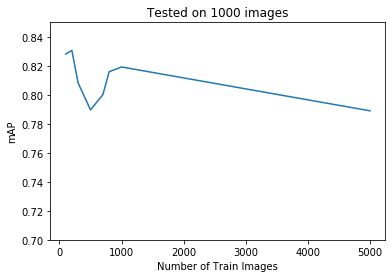

In [148]:
plt.plot(num_images, mAP)
plt.xlabel('Number of Train Images')
plt.ylabel('mAP')
plt.axis([None, None, 0.7, 0.85])
plt.title("Tested on 1000 images")
plt.show()

In [14]:
def get_nemo_test_image():
    """
    Function to load image locations, corresponding ground truth classes for classification from test
    
    return:
    A list with each individual image of the form
    [Image_location in str], [Ground truth of image classification]
    """
    # Reference the directory of the GVDL folder
    img_loc = path + '/nemo_test.list'
    data = [] 
    gt = []
    count = 0
    with open(img_loc, 'r') as f:
        reader = csv.reader(f, dialect='excel', delimiter='-')
        for row in reader:
            count += 1
            if (count == 5):
                break
            data.append(path + '/nemo_test/' + row[0] + '-' + row[1])
            gt.append(row[1][:-4])
    return data, gt

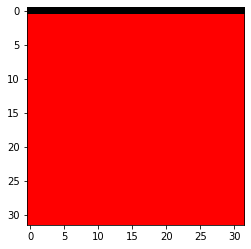

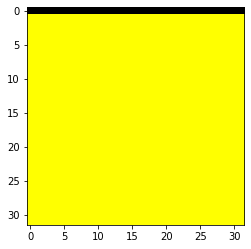

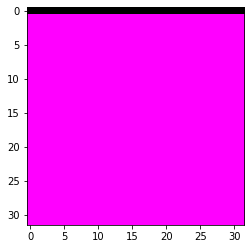

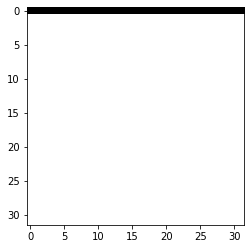

In [183]:
data,gt = get_nemo_test_image()
index_nemo_test = tuple(i for i in range(len(data)))
img_list_test = list(map(data_pool, index_nemo_test))
gt_list_test =  [gt[i] for i in range(len(data))]
predictions = nemo.predict_proba(img_list_test, omit_nothing = False)
# print("The testing gts are", gt_list_test[:])

In [185]:
print(gt)
print(predictions)

['blank', 'blank', 'blank', 'blank']
   Nothing I know  frog  truck  deer  automobile  bird  horse      ship  \
0             0.0   0.0    0.0   0.0         0.0   0.0    0.0  0.474473   
1             0.0   0.0    0.0   0.0         0.0   0.0    0.0  0.000000   
2             0.0   0.0    0.0   0.0         0.0   0.0    0.0  0.473480   
3             0.0   0.0    0.0   0.0         0.0   0.0    0.0  0.426558   

        cat  airplane  dog  
0  0.000000  0.525527  0.0  
1  0.443615  0.556385  0.0  
2  0.000000  0.526520  0.0  
3  0.000000  0.573442  0.0  


In [ ]:
nemo = pynemo.nemo(m_maxBatchSize=400
                       , m_maxNumNodes=400
                       , vigilance=0.01
                       , m_matchTracking=0.001
                       , m_learningRate=1.0
                       , m_instanceCounting=True
                       , m_complementCoding=False
                       , dominance=1.0
                       , goodness=100.0
                       , m_maxNodesPerClass=400
                       , m_postNormalize=1
                       , requested_threads=1
                       , classifier_type="Vector"
                       , device_index=-1
                       , is_input_prenormalized=False)

# 	ngap::ExpectationMatcherParameters nemoParams;
# 	nemoParams.m_vigilance = 0.01;
# 	nemoParams.m_dominance = 1.25;
# 	nemoParams.m_goodness = 2.75;
# 	nemoParams.m_matchTracking = -0.1;
# 	nemoParams.m_inputPrenormalized = true;